# Supervisor and worker based Multi-Agent System

### Environment Setup and API Configuration

This cell loads environment variables and configures API keys for the services used in this project.

We configure:
- GROQ_API_KEY for accessing the Groq-hosted LLM
- TAVILY_API_KEY for enabling Tavily web search

This ensures secure authentication without hardcoding credentials and supports secure deployment practices.


In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")

### Initializing the Language Model

Here we initialize the LLM using ChatGroq.

This model serves as:
- The reasoning engine for the Supervisor Agent
- The response generator for the final output node

The LLM is shared across all agents to maintain consistency in reasoning and language style.


In [2]:
from langchain_groq import ChatGroq

llm=ChatGroq(model="openai/gpt-oss-20b")

### Initializing Knowledge Source Tools

This cell sets up multiple tools representing different knowledge sources:

- Arxiv for academic and research papers  
- Wikipedia for general knowledge and definitions  
- Tavily for real-time web search and current information  

Each tool is later assigned to a specialized worker agent.


In [3]:
from langchain_community.tools import TavilySearchResults
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=300)
arxiv=ArxivQueryRun(api_wrapper=arxiv_wrapper)
wiki_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=300)
wiki=WikipediaQueryRun(api_wrapper=wiki_wrapper)
tavily_search=TavilySearchResults(max_results=2)

C:\Users\mouli\AppData\Local\Temp\ipykernel_3660\1220042474.py:8: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily_search=TavilySearchResults(max_results=2)


### Defining the Shared Graph State

This defines the state schema used by the LangGraph workflow.

The state includes:
- user_input: the original user query  
- collected_info: information gathered from multiple agents  
- next_action: the next agent selected by the supervisor  
- iteration_count: to prevent infinite loops  
- output: the final response  

This structure enables controlled data flow across agents.


In [4]:
from typing import TypedDict

class GraphState(TypedDict):
    user_input:str
    collected_info:list
    next_action:str
    iteration_count: int
    output:str

### Supervisor Agent Prompt Design

This prompt defines the behavior of the Supervisor Agent.

The supervisor:
- Decides which worker agent to call next  
- Tracks information collected so far  
- Prevents direct answering  
- Determines when sufficient information has been gathered  

This ensures separation of orchestration and reasoning responsibilities.


In [5]:
SUPERVISOR_PROMPT = """
You are a Supervisor Agent in a multi-agent system.

Your role:
- Decide which worker agent should be called next.
- Collect information from worker agents.
- Decide when enough information is gathered.
- When sufficient, route to the response node.

Available worker agents:
- tavily_worker → current events / web search
- wiki_worker → general knowledge / definitions
- arxiv_worker → research papers

Rules:
- Do NOT answer the user directly.
- Do NOT generate final responses.
- Only decide the NEXT action.
- You may call multiple workers iteratively.
- Stop and route to "response" when information is sufficient.

IMPORTANT:
- Do NOT call any tools
- Do NOT return JSON
- Do NOT return function calls
- Return ONLY ONE WORD:
  tavily_worker | wiki_worker | arxiv_worker | response

Output format (STRICT):
Return ONLY ONE of the following values:
- tavily_worker
- wiki_worker
- arxiv_worker
- response
"""


### Supervisor Agent Implementation

This function implements the Supervisor Agent.

Responsibilities:
- Analyze user query and collected information  
- Decide the next agent to invoke  
- Prevent tool usage or final answering  
- Enforce valid routing decisions  
- Apply a safety guard against infinite loops  

This is the core orchestration logic of the multi-agent system.


In [6]:

def supervisor(state: GraphState):
    print("--SUPERVISOR--")

    # # Safety guard to avoid infinite loops
    if state["iteration_count"] >= 10:
        return {"next_action": "response"}

    messages = [{"role": "system", "content": SUPERVISOR_PROMPT},
        {
            "role": "user",
            "content": f"""
            User query:
            {state['user_input']}

            Information collected so far:
            {state['collected_info']}
            """
        }]

    decision = llm.invoke(messages,tool_choice="none").content.strip().lower()

    #Hard validation (VERY IMPORTANT)
    allowed_actions = {
        "tavily_worker",
        "wiki_worker",
        "arxiv_worker",
        "response"
    }

    if decision not in allowed_actions:
        decision = "response"
    #print(decision)
    return {
        "next_action": decision,
        "iteration_count": state["iteration_count"] + 1
    }


### Tavily Worker Agent – Web and Current Events Specialist

This worker agent is responsible for:
- Fetching real-time information
- Handling current events
- Performing web-based searches using Tavily

It collects relevant information and adds it to the shared state.


In [7]:
def tavily_worker(state:GraphState):
    print("--TAVILY WORKER--")

    response = llm.bind_tools([tavily_search]).invoke(state["user_input"])

    if response.tool_calls:
        tool_args = response.tool_calls[0]["args"]
        tool_output = tavily_search.invoke(tool_args)

        info = f"[TavilySearch]\n{tool_output}"

    else:
        info = response.content or "No TavilySearch info found."

    return {
        "collected_info": state["collected_info"] + [info]
    }


### Wikipedia Worker Agent – General Knowledge Specialist

This worker agent handles:
- Definitions
- Explanatory queries
- General informational questions

It retrieves concise information from Wikipedia and appends it to the state.


In [8]:
def wiki_worker(state: GraphState):
    print("--WIKI WORKER--")

    response = llm.bind_tools([wiki]).invoke(state["user_input"])

    if response.tool_calls:
        tool_args = response.tool_calls[0]["args"]
        tool_output = wiki.invoke(tool_args)

        info = f"[Wikipedia]\n{tool_output}"

    else:
        info = response.content or "No Wikipedia info found."

    return {
        "collected_info": state["collected_info"] + [info]
    }


### Arxiv Worker Agent – Research and Academic Specialist

This worker agent is responsible for:
- Research paper queries
- Academic topics
- Technical and scientific knowledge

It retrieves relevant papers or summaries from Arxiv.


In [9]:
def arxiv_worker(state:GraphState):
    print("--ARXIV WORKER--")

    response = llm.bind_tools([arxiv]).invoke(state["user_input"])

    if response.tool_calls:
        tool_args = response.tool_calls[0]["args"]
        tool_output = arxiv.invoke(tool_args)

        info = f"[Arxiv]\n{tool_output}"

    else:
        info = response.content or "No ARXIV  info found."

    return {
        "collected_info": state["collected_info"] + [info]
    }


### Response Agent Prompt Design

This prompt defines the behavior of the Response Agent.

The response agent:
- Merges information from multiple worker agents
- Avoids hallucination
- Uses only collected information
- Produces a clear, concise final answer

This ensures grounded and trustworthy outputs.


In [10]:
RESPONSE_PROMPT = """
You are a Response Agent.

Your task:
- Use the collected information from multiple agents.
- Answer the user's query clearly and accurately.
- Do NOT introduce new information.
- Do NOT hallucinate.
- Base your answer ONLY on the provided information.

Guidelines:
- Merge overlapping points.
- Keep the response concise but complete.
- Structure the answer clearly.
"""


### Response Agent Implementation

This node generates the final user-facing response.

It uses:
- The original user query
- The information collected from all worker agents

It does not introduce new information, ensuring factual grounding.


In [11]:

def response(state: GraphState):
    print("--RESPONSE NODE--")

    messages = [{"role": "system", "content": RESPONSE_PROMPT},
        {
            "role": "user",
            "content": f"""
            User query:
            {state['user_input']}

            Collected information:
            {chr(10).join(state['collected_info'])}
            """
        }]

    final_answer = llm.invoke(messages).content

    return {
        "output": final_answer
    }


### Routing Function

This function reads the supervisor's decision and determines which agent node should execute next.

It enables LangGraph to dynamically control execution flow based on the supervisor’s output.


In [12]:
def route(state:GraphState):
    return state['next_action']

### Building the Multi-Agent Workflow with LangGraph

This cell constructs the full multi-agent system using LangGraph.

Flow:
Start → Supervisor  
Supervisor → Selected Worker  
Worker → Supervisor  
Supervisor → Response → End  

This enables iterative information gathering with centralized control.


In [13]:
from langgraph.graph import StateGraph,START,END

builder=StateGraph(GraphState)

builder.add_node("supervisor",supervisor)
builder.add_node("tavily_worker",tavily_worker)
builder.add_node("wiki_worker",wiki_worker)
builder.add_node("arxiv_worker",arxiv_worker)
builder.add_node("response",response)

builder.add_edge(START,"supervisor")
builder.add_conditional_edges("supervisor",route,
                              {
                                "tavily_worker":"tavily_worker",
                                "wiki_worker":"wiki_worker",
                                "arxiv_worker":"arxiv_worker",
                                "response":"response"
                              }
                              )

builder.add_edge("tavily_worker","supervisor")
builder.add_edge("wiki_worker","supervisor")
builder.add_edge("arxiv_worker","supervisor")

graph=builder.compile()

### Visualizing the Multi-Agent Workflow

This cell renders the LangGraph execution graph.

It helps visualize:
- The supervisor node
- Worker agents
- Iterative routing
- Final response node

This is extremely useful for debugging and system understanding.


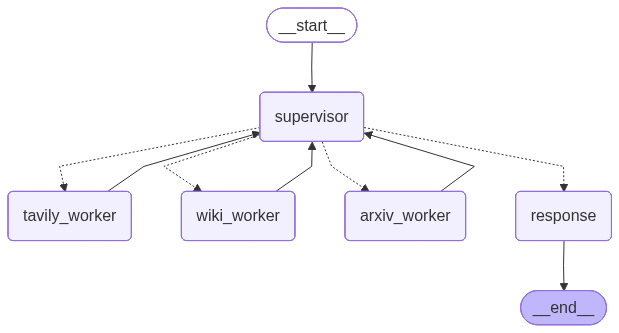

In [14]:
from IPython.display import display,Image
display(Image(graph.get_graph().draw_mermaid_png()))

### Running the Supervisor-Based Multi-Agent System

These examples demonstrate how the system:
- Routes queries to appropriate agents
- Iteratively gathers information
- Produces a final grounded response

This validates the full end-to-end multi-agent workflow.


In [25]:
response=graph.invoke({
    "user_input": "attention all you need",
    "routing": "",
    "collected_info": [],
    "output": "",
    "iteration_count": 0
})

print(response["output"])



--SUPERVISOR--
--WIKI WORKER--
--SUPERVISOR--
--WIKI WORKER--
--SUPERVISOR--
--ARXIV WORKER--
--SUPERVISOR--
--ARXIV WORKER--
--SUPERVISOR--
--RESPONSE NODE--
**Attention Is All You Need** (Vaswani et al., 2017) introduced the Transformer, a model that replaces recurrence and convolution with a **purely attention‑based** architecture.  
Below is a concise overview of its core ideas, structure, and impact.

| Component | What it does | Why it matters |
|-----------|--------------|----------------|
| **Scaled dot‑product self‑attention** | Each token attends to every other token via learned similarity scores. | Enables global context in one layer, allowing full parallelism. |
| **Multi‑head attention** | Parallel heads capture different relational “views” of the tokens. | Improves representation power without extra parameters. |
| **Positional encoding** | Adds order information (sinusoidal or learned) to token embeddings. | Gives the model a sense of sequence order. |
| **Encoder‑decode

In [24]:
response=graph.invoke({
    "user_input": "What is Agentic ai",
    "routing": "",
    "collected_info": [],
    "output": "",
    "iteration_count": 0
})

print(response["output"])

--SUPERVISOR--
--WIKI WORKER--
--SUPERVISOR--
--WIKI WORKER--
--SUPERVISOR--
--RESPONSE NODE--
**Agentic AI** (also known as **compound AI systems** or **AI agents**) is a class of intelligent systems that can operate autonomously in complex environments. These tools prioritize decision‑making and self‑directed action rather than merely generating content or responding to prompts.


In [23]:
response=graph.invoke({
    "user_input": "What is the recent ai updates in the last one week",
    "routing": "",
    "collected_info": [],
    "output": "",
    "iteration_count": 0
})
print(response["output"])

--SUPERVISOR--
--TAVILY WORKER--
--SUPERVISOR--
--TAVILY WORKER--
--SUPERVISOR--
--TAVILY WORKER--
--SUPERVISOR--
--TAVILY WORKER--
--SUPERVISOR--
--TAVILY WORKER--
--SUPERVISOR--
--RESPONSE NODE--
**AI developments that have emerged in the past week (January 2026)**  

| Date | Key update | What it means |
|------|------------|---------------|
| **Jan 19** | **JPMorgan Chase** re‑classifies its AI spend from experimental R&D to “core infrastructure.” The bank will invest in AI agents for internal productivity, AI‑powered cybersecurity, and personalized retail banking. | Signals a shift from pilot projects to enterprise‑scale, revenue‑directed AI adoption in finance. |
| | **SAP & Fresenius** announce a joint “sovereign” AI platform for healthcare, using SAP Business AI and SAP Business Data Cloud. The project will keep sensitive medical data on‑premises or in controlled clouds, with a mid‑three‑digit‑million‑euro investment. | Highlights growing demand for secure, regulated AI in regu